
# REBEL

## Introduction

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [128]:
from transformers import pipeline
import textwrap


triplet_extractor = pipeline('text2text-generation', model='Babelscape/rebel-large', tokenizer='Babelscape/rebel-large')

# We need to use the tokenizer manually since we need special tokens.

with (open("text.txt", "r", encoding="UTF-8") as f):
    f = f.read()
    sentences = textwrap.wrap(f, int(128*1.5), break_long_words=False)
    extracted_text = []
    
    for i,s in enumerate(sentences[0:15]):
        print(f'{i}/{5}')
        extracted_text.extend(triplet_extractor.tokenizer.batch_decode([triplet_extractor(s, return_tensors=True, return_text=False)[0]["generated_token_ids"]]))
        
    """extracted_text = triplet_extractor.tokenizer.batch_decode([triplet_extractor("Punta Cana is a resort town in the municipality of Higuey, in La Altagracia Province, the eastern most province of the Dominican Republic", return_tensors=True, return_text=False)[0]["generated_token_ids"]])"""
    """ extracted_text = triplet_extractor.tokenizer.batch_decode(
        [extractor["generated_token_ids"] for extractor in triplet_extractor(f.read(), return_tensors=True, return_text=False)])"""

print(extracted_text[0])


# Function to parse the generated text and extract the triplets
def extract_triplets(text):
    triplets = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    for token in text.replace("<s>", "").replace("<pad>", "").replace("</s>", "").split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(), 'tail': object_.strip()})
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(), 'tail': object_.strip()})
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        triplets.append({'head': subject.strip(), 'type': relation.strip(), 'tail': object_.strip()})
    return triplets

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0/5
1/5
2/5
3/5
4/5
5/5
6/5
7/5
8/5
9/5
10/5
11/5
12/5
13/5
14/5
<s><triplet> Everest Hinton <subj> 6 December 1947 <obj> date of birth <subj> computer scientist <obj> occupation</s>


In [129]:
extracted_triplets = []
for i in range(10):
    extracted_triplets.extend(extract_triplets(extracted_text[i]))
print(extracted_triplets)

[{'head': 'Everest Hinton', 'type': 'date of birth', 'tail': '6 December 1947'}, {'head': 'Everest Hinton', 'type': 'occupation', 'tail': 'computer scientist'}, {'head': 'Vector Institute', 'type': 'located in the administrative territorial entity', 'tail': 'Toronto'}, {'head': 'backpropagation', 'type': 'publication date', 'tail': '1986'}, {'head': 'Godfather of Deep', 'type': 'field of work', 'tail': 'deep learning'}, {'head': 'AlexNet', 'type': 'discoverer or inventor', 'tail': 'Alex Krizhevsky'}, {'head': 'Yoshua Bengio', 'type': 'award received', 'tail': 'Turing Prize'}, {'head': 'Yann LeCun', 'type': 'award received', 'tail': 'Turing Prize'}, {'head': 'experimental psychology', 'type': 'subclass of', 'tail': 'artificial intelligence'}, {'head': 'Christopher Longuet-Higgins', 'type': 'educated at', 'tail': 'University of Sussex'}, {'head': 'Computational Neuroscience Unit', 'type': 'part of', 'tail': 'University College London'}, {'head': 'Learning in Machines & Brains', 'type': '

In [88]:
extracted_triplets = extract_triplets(extracted_text[0])

In [130]:
import networkx as nx

G = nx.DiGraph()

relation = {}
k = 0
for i, elem in enumerate(extracted_triplets):
    if elem['tail'] not in relation:
        relation[elem['tail']] = k
        G.add_node(k, name = relation[elem['tail']])
        k += 1
        
    if elem['head'] not in relation:
        relation[elem['head']] = k
        G.add_node(k, name=elem['head'])
        k += 1

    G.add_edge(relation[elem['head']], relation[elem['tail']], name = elem['type'])

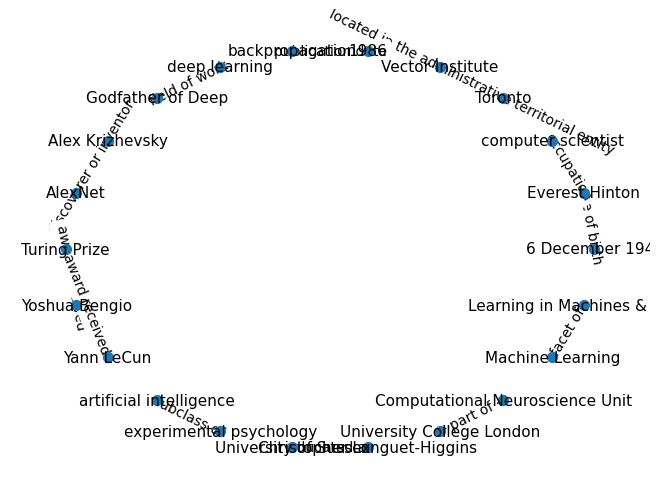

In [137]:
import matplotlib.pyplot as plt

inv_map = {v: k for k, v in relation.items()}
pos = nx.circular_layout(G)
edge_labels = dict([((n1, n2), d['name'])
                    for n1, n2, d in G.edges(data=True)])

options = {
    'labels':inv_map,
    'with_labels':True,
    'node_size': 50,
    'pos': pos,
    'font_size':11
}

nx.draw(G, **options)
nx.draw_networkx_edge_labels(G, pos,edge_labels=edge_labels)
plt.show()

Nous pouvons voir que les informations importantes du texte sont ici représenté par un graphe direct. Les termes importants sont représenté par des nœuds. Ces nœuds sont interconnecté par des arêtes qui ont été labellisés. Finalement, grâce à ce graphe, nous pouvons comprendre l'essentiel des informations contenues dans le paragraphe en faisant des liens avec les différentes idées. Par exemple, d'après le graphe ci-dessus, nous apprenons que Geoffrey Everest Hinton a travaillé dans le domaine des réseaux de neurones et qu'il était employé à l'Université de Toronto.

Cependant, l'algorithme REBEL ne nous permet d'analyser tout le texte d'un seul coup. Il faut pour cela analyser des sous-parties du texte. Nous obtenons alors un graphe différent pour chacun de ces sous-parties. Si nous avons de la chance, ces sous-graphes pourront s'inter-connecté (par exemple avec la répétition du même sujet) et ainsi nous donner un seul graphe pour l'ensemble du texte. Malheureusement, même en utilisant des séquences avec une longueur de 128, nous obtenons que des sous-graphes indépendants. Ainsi, le texte n'est pas assez riche pour être analysés correctement avec l'algorithme REBEL.

L'algorithme REBEL est un modèle de text2text basé sur le modèle BERT. Le dataset utilisé pour l'entrainement de REBEL sont les relations trouvées dans les pages Wikipédia et Wikidata et qui ont ensuite été filtré par RoBERTa.